# Image Captioning - Model Training

In this notebook, we will train the image captioning model using the pre-extracted features from the CNN encoder. We will:

1. Set up the data loaders for training and validation
2. Build the caption model (combining the encoder and decoder)
3. Define the training pipeline with teacher forcing
4. Train the model with appropriate hyperparameters
5. Monitor the training progress and validation performance
6. Save the trained model for later evaluation

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import h5py

# Add project root to path
from google.colab import drive
drive.mount('/content/drive')
project_root = '/content/drive/MyDrive/image-captioning-main'
sys.path.append(project_root)

# Import project modules
from models.encoder import EncoderCNN
from models.decoder import DecoderRNN
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.trainer import CaptionTrainer

Mounted at /content/drive


### CNN CHECK

In [ ]:
# Setup
import torch
from models.encoder import EncoderCNN
from PIL import Image
from torchvision import transforms

# Dummy image tensor
image_path = "/content/drive/MyDrive/image-captioning-main/data/flickr8k/processed/images/3767841911_6678052eb6.jpg"
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0)  # [1, 3, 224, 224]

# Encoder
encoder = EncoderCNN(model_name='resnet18', embed_size=256, pretrained=True, trainable=False)
encoder.eval()
with torch.no_grad():
    features = encoder(image_tensor)

print("Encoder output shape:", features.shape)
print("Encoder output mean:", features.mean().item())
print("Encoder output std:", features.std().item())


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Encoder output shape: torch.Size([1, 256])
Encoder output mean: 0.2199319303035736
Encoder output std: 0.33237406611442566


In [ ]:
import torch
from models.decoder import DecoderRNN

# Settings (adjust to your config)
vocab_size = 5000
embed_size = 256
hidden_size = 512
seq_length = 20
batch_size = 2

# Create dummy data
features = torch.randn(batch_size, embed_size)             # From encoder
captions = torch.randint(0, vocab_size, (batch_size, seq_length))  # Simulated caption indices

# Initialize decoder
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=1, rnn_type='lstm')
decoder.eval()

# Forward pass
with torch.no_grad():
    outputs, hidden = decoder(features, captions)

print("Decoder output shape:", outputs.shape)  # [B, T, V]
print("Output (sample logits):", outputs[0, 0, :5])  # Show first token logits


Decoder output shape: torch.Size([2, 20, 5000])
Output (sample logits): tensor([-0.0238, -0.0175, -0.1365, -0.0901,  0.0239])


## 1. Configuration Settings

In [ ]:
# Define configuration settings
config = {
    # Data settings
    'data_dir': '/content/drive/MyDrive/image-captioning-main/data/flickr8k',
    'batch_size': 64,
    'num_workers': 4,

    # Model settings
    'encoder_model': 'resnet18',  # Options: 'resnet18', 'resnet50', 'mobilenet_v2' , 'inception_v3'
    'embed_size': 256,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.5,
    'decoder_type': 'lstm',  # Options: 'lstm', 'gru'
    'vocab_size': 3000, # Decided based on notebook-1

    # Training settings
    'learning_rate': 1e-3, # 10^-3
    'num_epochs': 15,  # Increase for better results
    'early_stopping_patience': 5,
    'save_dir': '/content/drive/MyDrive/image-captioning-main/models',
    'data_dir': '/content/drive/MyDrive/image-captioning-main/data/flickr8k',

    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create save directory if it doesn't exist
os.makedirs(config['save_dir'], exist_ok=True)

# Print configuration
for section, items in {
    'Data': ['data_dir', 'batch_size', 'num_workers'],
    'Model': ['encoder_model', 'embed_size', 'hidden_size', 'num_layers', 'dropout', 'decoder_type'],
    'Training': ['learning_rate', 'num_epochs', 'early_stopping_patience', 'save_dir'],
    'Device': ['device']
}.items():
    print(f"\n{section} settings:")
    for item in items:
        print(f"  {item}: {config[item]}")


Data settings:
  data_dir: /content/drive/MyDrive/image-captioning-main/data/flickr8k
  batch_size: 64
  num_workers: 4

Model settings:
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm

Training settings:
  learning_rate: 0.001
  num_epochs: 15
  early_stopping_patience: 5
  save_dir: /content/drive/MyDrive/image-captioning-main/models

Device settings:
  device: cuda


## 2. Load Data

In [ ]:
# Get data loaders
train_loader, val_loader, test_loader, vocab = get_data_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# Update vocabulary size in config
config['vocab_size'] = len(vocab)
print(f"Vocabulary size: {config['vocab_size']}")

# Display data loader information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Vocabulary size: 2986
Training batches: 93
Validation batches: 16
Test batches: 1000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3. Create Model

In [ ]:
# Create caption model
model = CaptionModel(
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    vocab_size=config['vocab_size'],
    num_layers=config['num_layers'],
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=config['dropout'],
    train_encoder=False  # Don't train the encoder (use pre-trained weights)
)

# Print model architecture
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.4MB/s]


CaptionModel(
  (encoderCNN): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

Number of trainable parameters: 4005034
Encoder parameters: 131840 (3.3%)
Decoder parameters: 3873194 (96.7%)


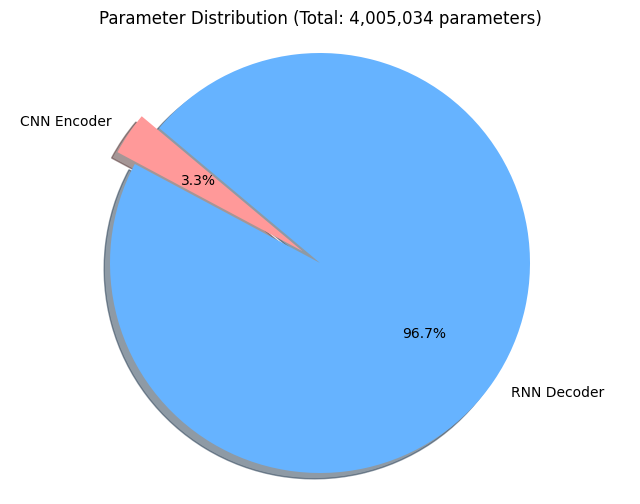

In [ ]:
# Calculate model size
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    num_of_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_of_trainable_parameters

# Calculate and print model size
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Calculate encoder and decoder sizes separately
encoder_params = count_parameters(model.encoderCNN)
decoder_params = count_parameters(model.decoderRNN)
print(f"Encoder parameters: {encoder_params} ({encoder_params / num_params * 100:.1f}%)")
print(f"Decoder parameters: {decoder_params} ({decoder_params / num_params * 100:.1f}%)")

sizes = [encoder_params, decoder_params]
labels = ['CNN Encoder', 'RNN Decoder']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 1st slice (Encoder)

# Create the pie plot
plt.figure(figsize=(8, 6))
plt.pie(sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        shadow=True,
        startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title(f'Parameter Distribution (Total: {num_params:,} parameters)')
plt.show()

## 4. Train the Model

In [ ]:
# Create trainer
trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=config['device'],
    learning_rate=config['learning_rate'],
    model_save_dir=config['save_dir'],
    data_dir=config['data_dir']
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import nltk
try:
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=10  # Generate captions and calculate BLEU every 5 epochs
)

Starting training for 15 epochs...
Training on device: cuda


Epoch 1: 100%|██████████| 468/468 [12:50<00:00,  1.65s/it]


[DEBUG] Gradient L2 norm: 0.2824
Epoch 1 - Train Loss: 0.0171
Generated: steers fishing pulling motorcyclists european castle trash scantily strings homemade poses stall waiting hairy posed tunnel carring noses along clowns
Target   : the collie is running down blue and yellow board
Epoch 1 - Val Loss: 7.9802
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 1/15 completed in 887.88s - Train Loss: 0.0171, Val Loss: 7.9802


Epoch 2: 100%|██████████| 468/468 [04:02<00:00,  1.93it/s]


[DEBUG] Gradient L2 norm: 0.2922
Epoch 2 - Train Loss: 0.0171
Generated: man desk transportation pierced males attacking of relaxes almost bookstore mouse relaxes used leaps relaxes helmet sister women bride do
Target   : dog jumping for frisbee in field
Epoch 2 - Val Loss: 7.9497
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 2/15 completed in 286.76s - Train Loss: 0.0171, Val Loss: 7.9497


Epoch 3: 100%|██████████| 468/468 [04:07<00:00,  1.89it/s]


[DEBUG] Gradient L2 norm: 0.2917
Epoch 3 - Train Loss: 0.0170
Generated: man man corndogs group people onstage left <UNK>
Target   : kids are standing in the sprinklers getting soaked with water
Epoch 3 - Val Loss: 7.9138
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 3/15 completed in 290.27s - Train Loss: 0.0170, Val Loss: 7.9138


Epoch 4: 100%|██████████| 468/468 [04:08<00:00,  1.88it/s]


[DEBUG] Gradient L2 norm: 0.3027
Epoch 4 - Train Loss: 0.0169
Generated: man in the the
Target   : the child is holding camera up close
Epoch 4 - Val Loss: 7.8685
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 4/15 completed in 291.20s - Train Loss: 0.0169, Val Loss: 7.8685


Epoch 5: 100%|██████████| 468/468 [04:05<00:00,  1.91it/s]


[DEBUG] Gradient L2 norm: 0.3237
Epoch 5 - Train Loss: 0.0168
Generated: group man in the
Target   : young man running on sidewalk with graffiti in the background
Epoch 5 - Val Loss: 7.8062
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 5/15 completed in 287.88s - Train Loss: 0.0168, Val Loss: 7.8062


Epoch 6: 100%|██████████| 468/468 [04:06<00:00,  1.90it/s]


[DEBUG] Gradient L2 norm: 0.3538
Epoch 6 - Train Loss: 0.0167
Generated: two man in the
Target   : dog carries stick in its mouth
Epoch 6 - Val Loss: 7.7136
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 6/15 completed in 290.41s - Train Loss: 0.0167, Val Loss: 7.7136


Epoch 7: 100%|██████████| 468/468 [04:11<00:00,  1.86it/s]


[DEBUG] Gradient L2 norm: 0.4218
Epoch 7 - Train Loss: 0.0165
Generated: man man in the
Target   : woman competing in the long jump photographed in midair
Epoch 7 - Val Loss: 7.5614
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 7/15 completed in 293.82s - Train Loss: 0.0165, Val Loss: 7.5614


Epoch 8: 100%|██████████| 468/468 [04:12<00:00,  1.86it/s]


[DEBUG] Gradient L2 norm: 0.5222
Epoch 8 - Train Loss: 0.0162
Generated: man in the
Target   : man and woman standing underneath the tree are talking
Epoch 8 - Val Loss: 7.2859
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 8/15 completed in 295.40s - Train Loss: 0.0162, Val Loss: 7.2859


Epoch 9: 100%|██████████| 468/468 [04:09<00:00,  1.87it/s]


[DEBUG] Gradient L2 norm: 0.7413
Epoch 9 - Train Loss: 0.0158
Generated: man in the
Target   : brown dog <UNK> on grass
Epoch 9 - Val Loss: 6.8427
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 9/15 completed in 292.65s - Train Loss: 0.0158, Val Loss: 6.8427


Epoch 10: 100%|██████████| 468/468 [04:07<00:00,  1.89it/s]


[DEBUG] Gradient L2 norm: 1.0795
Epoch 10 - Train Loss: 0.0150
Generated: man in the
Target   : two children are practicing boogie boarding in the ocean


Generating captions: 100%|██████████| 5000/5000 [08:12<00:00, 10.16it/s]


Epoch 10 - Val Loss: 6.4058, BLEU-4: 0.0079
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_bleu.pth
Epoch 10/15 completed in 786.75s - Train Loss: 0.0150, Val Loss: 6.4058, BLEU-4: 0.0079


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11: 100%|██████████| 468/468 [04:07<00:00,  1.89it/s]


[DEBUG] Gradient L2 norm: 1.1928
Epoch 11 - Train Loss: 0.0138
Generated: man in
Target   : dog is running in the ocean beside the beach
Epoch 11 - Val Loss: 6.1662
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 11/15 completed in 289.81s - Train Loss: 0.0138, Val Loss: 6.1662


Epoch 12: 100%|██████████| 468/468 [04:09<00:00,  1.88it/s]


[DEBUG] Gradient L2 norm: 0.7524
Epoch 12 - Train Loss: 0.0133
Generated: man with
Target   : there are three women wearing different dresses and <UNK> dancing in the street
Epoch 12 - Val Loss: 6.1495
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 12/15 completed in 293.82s - Train Loss: 0.0133, Val Loss: 6.1495


Epoch 13: 100%|██████████| 468/468 [04:12<00:00,  1.85it/s]


[DEBUG] Gradient L2 norm: 1.3282
Epoch 13 - Train Loss: 0.0132
Generated: man in
Target   : person rides their bicycle onto rock and balances on one wheel
Epoch 13 - Val Loss: 6.1691
Epoch 13/15 completed in 296.28s - Train Loss: 0.0132, Val Loss: 6.1691


Epoch 14: 100%|██████████| 468/468 [04:07<00:00,  1.89it/s]


[DEBUG] Gradient L2 norm: 1.5784
Epoch 14 - Train Loss: 0.0136
Generated: man in the
Target   : football player quarterback in red sooners jersey and red helmet prepares to <UNK> snap
Epoch 14 - Val Loss: 6.1479
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 14/15 completed in 291.74s - Train Loss: 0.0136, Val Loss: 6.1479


Epoch 15: 100%|██████████| 468/468 [04:12<00:00,  1.85it/s]

[DEBUG] Gradient L2 norm: 1.4071
Epoch 15 - Train Loss: 0.0133
Generated: man in the
Target   : three people backpacking across large snowy and rocky field


Epoch 15 - Val Loss: 6.0987
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 15/15 completed in 295.70s - Train Loss: 0.0133, Val Loss: 6.0987
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/final_model.pth
Training completed!
Best validation loss: 6.0987
Best BLEU-4 score: 0.0079


In [ ]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=5  # Generate captions and calculate BLEU every 5 epochs
)

Starting training for 15 epochs...
Training on device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1: 100%|██████████| 93/93 [19:33<00:00, 12.62s/it]


[DEBUG] Gradient L2 norm: 0.2852
Epoch 1 - Train Loss: 0.0861
Generated: abandoned three vehicles musicians trench electronic paper apron small beard khaki festival sidecar pursued choppy cold trench sled glove pasture
Target   : boy does cartwheel on rock cliff
Epoch 1 - Val Loss: 7.9818
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 1/15 completed in 1377.77s - Train Loss: 0.0861, Val Loss: 7.9818


Epoch 2: 100%|██████████| 93/93 [00:54<00:00,  1.70it/s]


[DEBUG] Gradient L2 norm: 0.2794
Epoch 2 - Train Loss: 0.0859
Generated: brown man parade inspecting muzzles security spectators pokes tossed turquoise dancers parent jockeys whilst motorbike cape mountains parade canyon herd
Target   : cyclist leaning forward as he <UNK> his bike
Epoch 2 - Val Loss: 7.9565
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 2/15 completed in 63.92s - Train Loss: 0.0859, Val Loss: 7.9565


Epoch 3: 100%|██████████| 93/93 [00:51<00:00,  1.79it/s]


[DEBUG] Gradient L2 norm: 0.2879
Epoch 3 - Train Loss: 0.0857
Generated: two gym dogs bites golf card chairs kitten waiter coats motorcycle fountain golden short boa drops skateboard kangaroo mirror tutu
Target   : the skateboarder in the white shirt balances on the ledge as the others look
Epoch 3 - Val Loss: 7.9272
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 3/15 completed in 62.28s - Train Loss: 0.0857, Val Loss: 7.9272


Epoch 4: 100%|██████████| 93/93 [00:53<00:00,  1.74it/s]


[DEBUG] Gradient L2 norm: 0.2893
Epoch 4 - Train Loss: 0.0854
Generated: man and in the the
Target   : man throwing frisbee
Epoch 4 - Val Loss: 7.8917
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 4/15 completed in 62.51s - Train Loss: 0.0854, Val Loss: 7.8917


Epoch 5: 100%|██████████| 93/93 [00:50<00:00,  1.82it/s]


[DEBUG] Gradient L2 norm: 0.2975
Epoch 5 - Train Loss: 0.0851
Generated: two dogs
Target   : group of people are getting fountain drinks at <UNK> store


Generating captions: 100%|██████████| 1000/1000 [12:29<00:00,  1.33it/s]


Epoch 5 - Val Loss: 7.8460, BLEU-4: 0.0000
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_bleu.pth
Epoch 5/15 completed in 820.33s - Train Loss: 0.0851, Val Loss: 7.8460, BLEU-4: 0.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6: 100%|██████████| 93/93 [00:54<00:00,  1.72it/s]


[DEBUG] Gradient L2 norm: 0.3314
Epoch 6 - Train Loss: 0.0845
Generated: man and two women
Target   : woman in blue running next to black and white dog as it jumps over
Epoch 6 - Val Loss: 7.7823
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 6/15 completed in 63.14s - Train Loss: 0.0845, Val Loss: 7.7823


Epoch 7: 100%|██████████| 93/93 [00:50<00:00,  1.83it/s]


[DEBUG] Gradient L2 norm: 0.3845
Epoch 7 - Train Loss: 0.0837
Generated: man and woman
Target   : there is beige and white dog running through water
Epoch 7 - Val Loss: 7.6864
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 7/15 completed in 60.74s - Train Loss: 0.0837, Val Loss: 7.6864


Epoch 8: 100%|██████████| 93/93 [00:49<00:00,  1.87it/s]


[DEBUG] Gradient L2 norm: 0.4332
Epoch 8 - Train Loss: 0.0830
Generated: two dogs
Target   : toddler in pink dress walks through the grass
Epoch 8 - Val Loss: 7.5283
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 8/15 completed in 59.71s - Train Loss: 0.0830, Val Loss: 7.5283


Epoch 9: 100%|██████████| 93/93 [00:51<00:00,  1.79it/s]


[DEBUG] Gradient L2 norm: 0.5220
Epoch 9 - Train Loss: 0.0817
Generated: man and
Target   : the girls are dressed up in silver and white and their hair is <UNK>
Epoch 9 - Val Loss: 7.2483
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 9/15 completed in 61.10s - Train Loss: 0.0817, Val Loss: 7.2483


Epoch 10: 100%|██████████| 93/93 [00:49<00:00,  1.89it/s]


[DEBUG] Gradient L2 norm: 0.7854
Epoch 10 - Train Loss: 0.0786
Generated: man in
Target   : greyhound dogs are running towards camera on track


Generating captions: 100%|██████████| 1000/1000 [00:16<00:00, 59.31it/s]


Epoch 10 - Val Loss: 6.8145, BLEU-4: 0.0000
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_bleu.pth
Epoch 10/15 completed in 77.06s - Train Loss: 0.0786, Val Loss: 6.8145, BLEU-4: 0.0000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11: 100%|██████████| 93/93 [00:52<00:00,  1.76it/s]


[DEBUG] Gradient L2 norm: 1.0635
Epoch 11 - Train Loss: 0.0745
Generated: two the
Target   : brown and white dog jumping over red and yellow pole
Epoch 11 - Val Loss: 6.3906
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 11/15 completed in 62.99s - Train Loss: 0.0745, Val Loss: 6.3906


Epoch 12: 100%|██████████| 93/93 [00:51<00:00,  1.80it/s]


[DEBUG] Gradient L2 norm: 1.1721
Epoch 12 - Train Loss: 0.0690
Generated: two dog
Target   : the brown and white dog is standing up on its hind legs
Epoch 12 - Val Loss: 6.1652
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 12/15 completed in 60.51s - Train Loss: 0.0690, Val Loss: 6.1652


Epoch 13: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s]


[DEBUG] Gradient L2 norm: 0.7690
Epoch 13 - Train Loss: 0.0681
Generated: man
Target   : there is very <UNK> <UNK> woman on pink towel <UNK> on lawn chair next
Epoch 13 - Val Loss: 6.1546
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/best_model_loss.pth
Epoch 13/15 completed in 61.44s - Train Loss: 0.0681, Val Loss: 6.1546


Epoch 14: 100%|██████████| 93/93 [00:50<00:00,  1.82it/s]


[DEBUG] Gradient L2 norm: 1.2455
Epoch 14 - Train Loss: 0.0656
Generated: two man in
Target   : the bike rider rides in wooded area
Epoch 14 - Val Loss: 6.1836
Epoch 14/15 completed in 59.44s - Train Loss: 0.0656, Val Loss: 6.1836


Epoch 15: 100%|██████████| 93/93 [00:50<00:00,  1.82it/s]


[DEBUG] Gradient L2 norm: 1.6775
Epoch 15 - Train Loss: 0.0673
Generated: two the
Target   : group of children are in water fountain


Generating captions: 100%|██████████| 1000/1000 [00:17<00:00, 56.32it/s]


Epoch 15 - Val Loss: 6.1695, BLEU-4: 0.0000
Epoch 15/15 completed in 79.11s - Train Loss: 0.0673, Val Loss: 6.1695, BLEU-4: 0.0000
Model checkpoint saved to /content/drive/MyDrive/image-captioning-main/models/final_model.pth
Training completed!
Best validation loss: 6.1546
Best BLEU-4 score: 0.0000


## 5. Analyze Training Results
- before adding label smoothing and increasing the learning rate

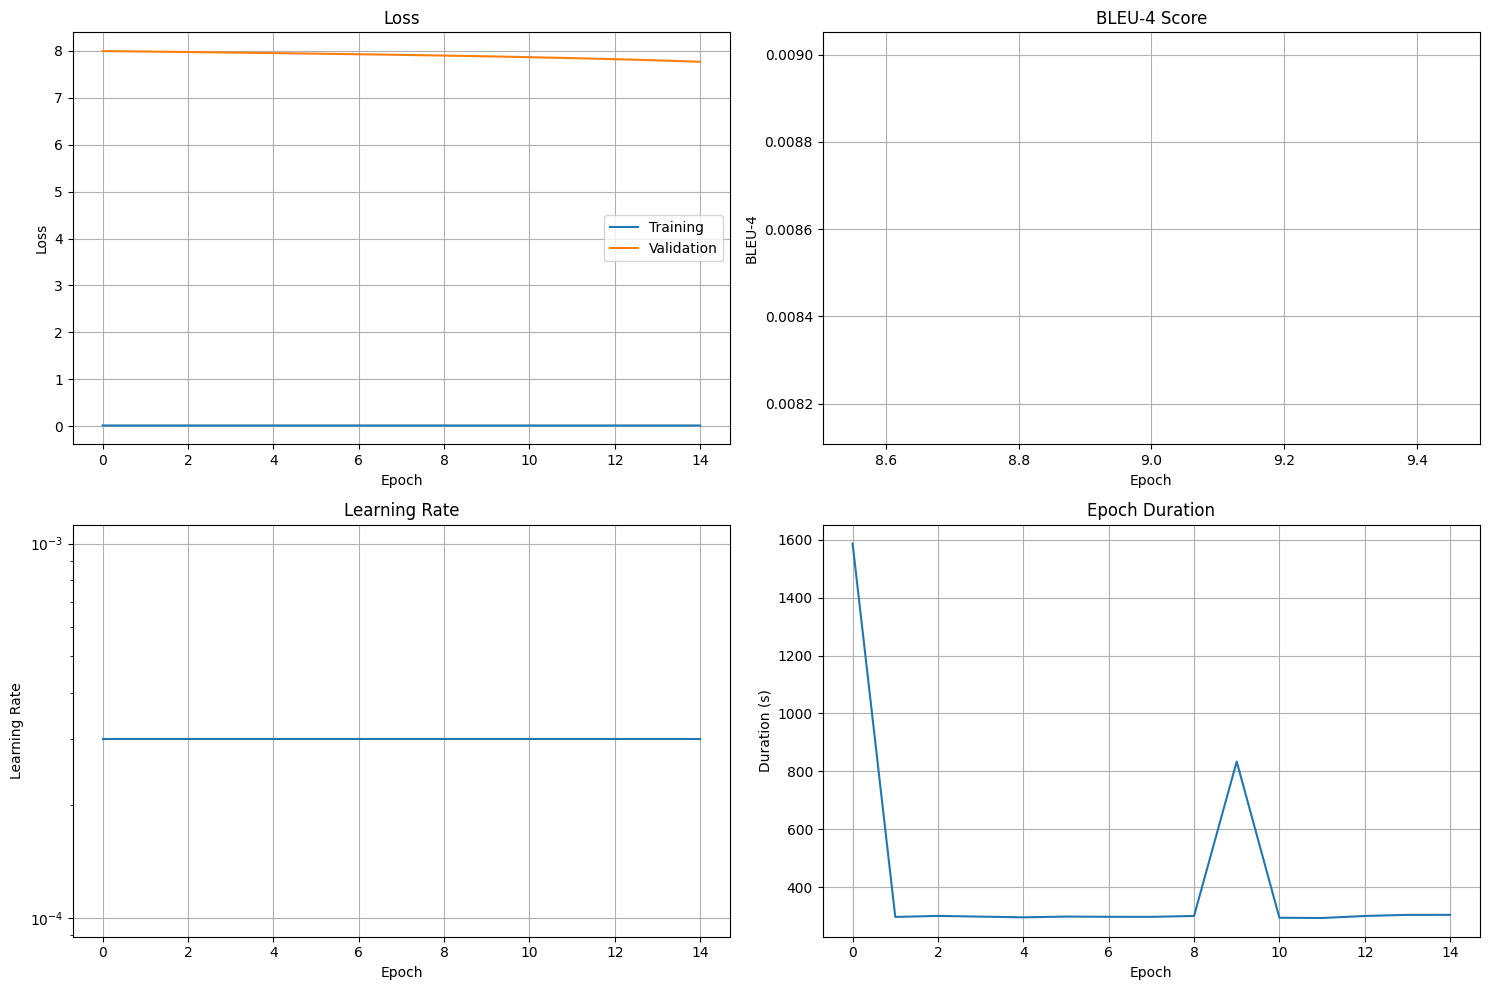

In [ ]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

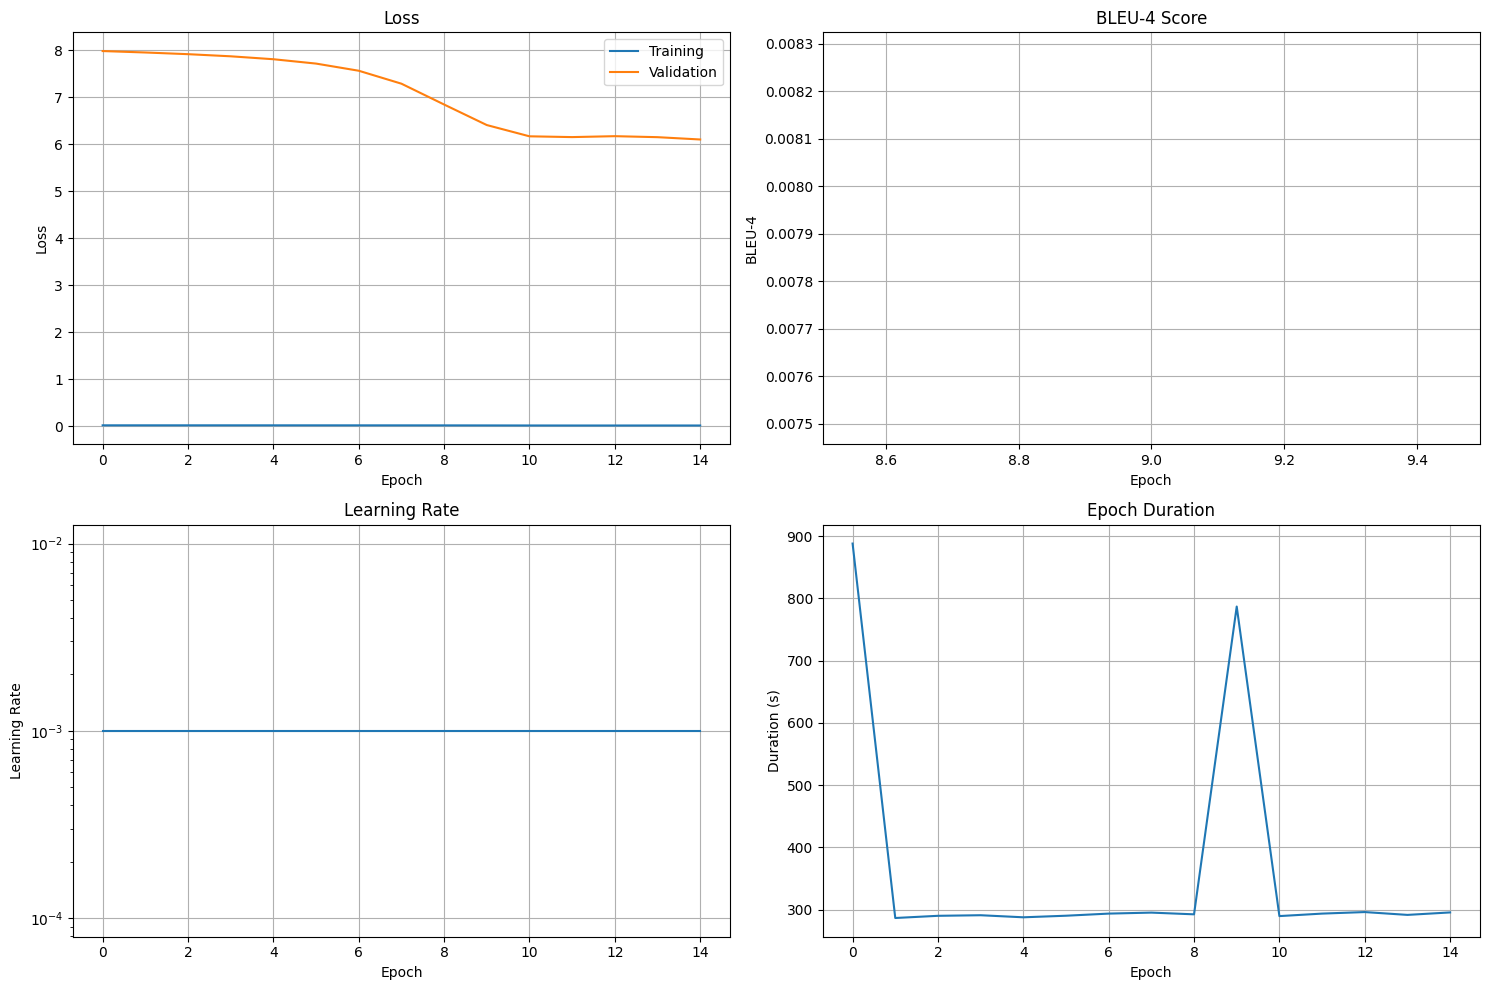

In [ ]:
# Plot training history : after :
fig, axs = trainer.plot_history()
plt.show()

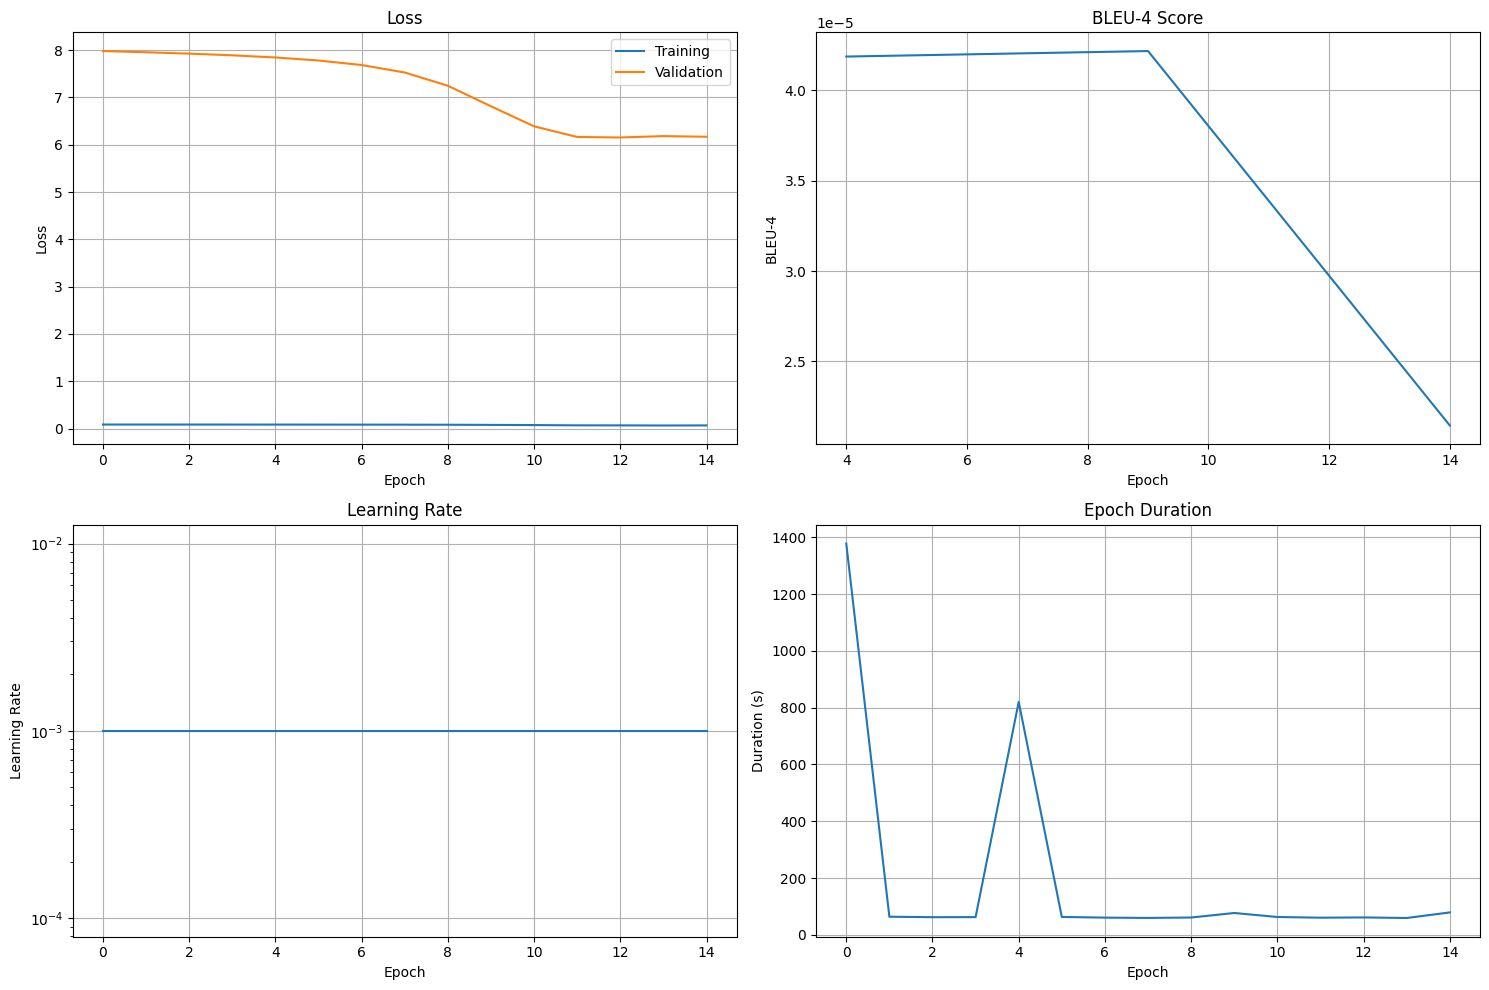

In [ ]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

In [ ]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 15
Best validation loss: 7.7673
Best BLEU epoch: 10
Best BLEU score: 0.0086


In [ ]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 15
Best validation loss: 6.0987
Best BLEU epoch: 10
Best BLEU score: 0.0079


In [ ]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 13
Best validation loss: 6.1546
Best BLEU epoch: 10
Best BLEU score: 0.0000


## 6. Generate Sample Captions

In [ ]:
# Generate captions for some validation images
def generate_caption(image, model, vocab, device):
    """Generate a caption for an image."""
    #-------------------------------------------------------------------------------------------
    # TODO: Implement the caption generation function
    # 1. Set the model to evaluation mode
    # 2. Use torch.no_grad() to disable gradient calculation during inference
    # 3. Move the image to the device and add a batch dimension if needed
    # 4. Generate a caption using the model's generate_caption method
    # 5. Decode the caption indices to text using the vocabulary
    # 6. Return the caption text

    # 1.
    model.eval()
    # 2.
    with torch.no_grad():
        if image.dim() == 3:
          # 3. Add batch dimension [1, 3, H, W]
            image = image.unsqueeze(0)

        image = image.to(device)  # Move to device
        # 4.
        output_ids = model.generate_caption(image)
        # 5.
        caption_text = vocab.decode(output_ids, join=True, remove_special=True)

    return caption_text
    #-------------------------------------------------------------------------------------------

    num_examples = 5
    val_examples = []

    val_iter = iter(val_loader)
    while len(val_examples) < num_examples:
        try:
            images, captions = next(val_iter)
        except StopIteration:
            break  # Stop if the loader runs out
    import random

    indices = random.sample(range(len(val_loader.dataset)), num_examples)
    val_examples = []

    for idx in indices:
        image, caption, _ = val_loader.dataset[idx]
        true_caption = vocab.decode(caption, join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])

        val_examples.append({
            'image': image,
            'image_id': f"Image {idx}",
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })
    # Display examples
    plt.figure(figsize=(15, 5 * num_examples))

    for i, example in enumerate(val_examples):
        plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Image: {example['image_id']}") # This will now use the placeholder
    plt.axis('off')
    plt.figtext(0.5, 0.01 + i * (1/num_examples), f"True caption: {example['true_caption']}",
                ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.figtext(0.5, 0.05 + i * (1/num_examples), f"Generated caption: {example['generated_caption']}",
                ha='center', fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

## 7. Compare Greedy and Beam Search Decoding

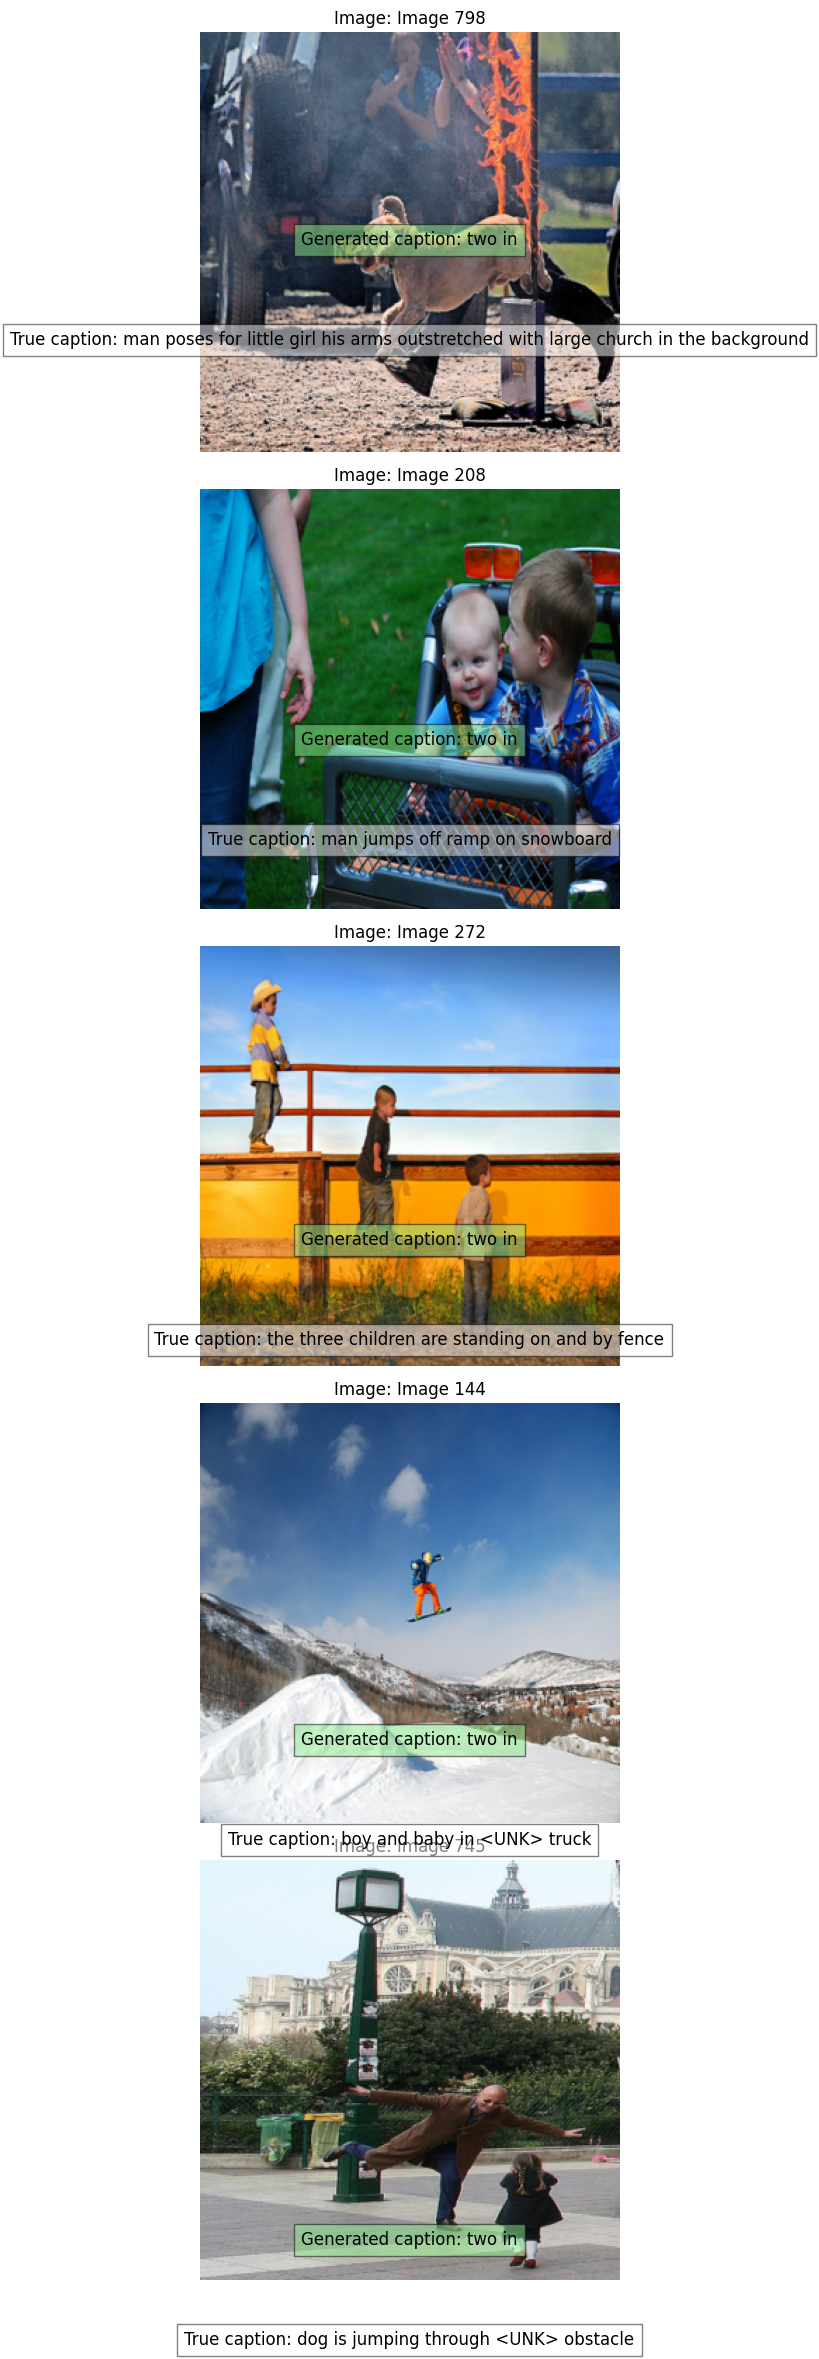

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np


def generate_caption(image, model, vocab, device):
    """Generate a caption for an image."""
    model.eval()
    with torch.no_grad():
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
        output_ids = model.generate_caption(image)
        caption_text = vocab.decode(output_ids, join=True, remove_special=True)
    return caption_text


num_examples = 5
val_examples = []

indices = random.sample(range(len(val_loader.dataset)), num_examples)
for idx in indices:
    image, caption = val_loader.dataset[idx]
    true_caption = vocab.decode(caption, join=True, remove_special=True)
    generated_caption = generate_caption(image, model, vocab, config['device'])

    val_examples.append({
        'image': image,
        'image_id': f"Image {idx}",
        'true_caption': true_caption,
        'generated_caption': generated_caption
    })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))
for i, example in enumerate(val_examples):
    plt.subplot(num_examples, 1, i + 1)
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Image: {example['image_id']}")
    plt.axis('off')
    plt.figtext(0.5, 0.01 + i * (1/num_examples), f"True caption: {example['true_caption']}",
                ha='center', fontsize=12, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})
    plt.figtext(0.5, 0.05 + i * (1/num_examples), f"Generated caption: {example['generated_caption']}",
                ha='center', fontsize=12, bbox={"facecolor": "lightgreen", "alpha": 0.5, "pad": 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 8. Save Final Model and Configuration

In [ ]:
# Save configuration
import json
config_path = os.path.join(config['save_dir'], 'config.json')

# Convert non-serializable values to strings
serializable_config = {k: str(v) if not isinstance(v, (int, float, str, bool)) else v
                      for k, v in config.items()}

with open(config_path, 'w') as f:
    json.dump(serializable_config, f, indent=4)

print(f"Configuration saved to {config_path}")

Configuration saved to /content/drive/MyDrive/image-captioning-main/models/config.json


In [ ]:
# Save vocabulary separately for easy access
import pickle
vocab_path = os.path.join(config['save_dir'], 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Vocabulary saved to {vocab_path}")

Vocabulary saved to /content/drive/MyDrive/image-captioning-main/models/vocabulary.pkl


## Summary

In this notebook, we have successfully:

1. Set up the data loaders for training and validation
2. Built the caption model by combining the encoder and decoder
3. Trained the model with teacher forcing
4. Monitored the training progress and validation performance
5. Generated captions for sample images
6. Compared different decoding strategies (greedy vs. beam search)
7. Saved the model, configuration, and vocabulary for later use

In the next notebook, we will perform a comprehensive evaluation of the model on the test set.